# Are we computing inefficiently?

##### Main take away 🗣️ 

- **Computational efficiency is the same** compared to control runs
- Increasing the **number of nodes slightly decreases efficiency**
- A 40 day run (DOM01+DOM02) requires **115200 node hours**

## Short description of computational complexity

We want to run expensive simulations. But how expensive are they exaclty? We use ICON-LES with three nested computing domains (= grids) that have decreasing size, but increasing grid spacing towards the inner domains. Domains 1, 2 and 3 have 4.5, 12 and 24 million cells respectively. The outer domains are run both for around 40 days. The innermost domain is so expensive that it was only run for 7 days in the control setup and I do not plan to use it at all for my standard warming setup. The timestep for all domains is 6 seconds.

## An efficiency metric

Usually we speak about the throughput we can achieve, usually given in simulated days per day. This is a useful measure for the feasiblity of a study but it does not consider resource use. Computing resources are measured in node hours (one computing node used for one hour equals one node hour). In the following we will use **simulated seconds per node hour used**. This measure is only comparable for two simulations of the same complexity. As soon as we want to compare high resolution to low resolution we have to take into account how big the grid is that we operate on. Here one could try to estimate how many cells can be advanced by one time time step in one node hour (*computations per node hour*). 

## DOM01 vs. DOM01+DOM02

In the runs we will compare here, the third domain was never used. And although I tried to postpone the startup of the inner domain *DOM02*, I later learned that the resources for the inner domain are blocked from the start of the script (pers.comm. Kluft, November 2023). In effect we might be faster without *DOM02* because we are not waiting for its processes to communicate, but the nodes for the second domain are already assigned and not available for the outer domain *DOM01*.

## Reading log files

We will base our estimate on logfiles and compare the computing efficiency achieved in runs by myself with the one achieved by Hauke Schulzes runs. To get the numbers we need from the logfiles we filter for specific keywords.

In [2]:
def find_matching_lines(file_path, keyword):
    """
    Search for lines in a text file that contain a specified keyword.

    Args:
        file_path (str): The path to the text file to be searched.
        keyword (str): The keyword to search for within the lines of the file.

    Returns:
        list: A list of lines from the file that contain the specified keyword.
        
    Raises:
        FileNotFoundError: If the specified file cannot be found.
        IOError: If there is an issue reading the file.
    """
    try:
        matching_lines = []
        with open(file_path, 'r') as file:
            for line in file:
                if keyword in line:
                    matching_lines.append(line.strip())  # .strip() to remove newline characters
        return matching_lines
    except FileNotFoundError: raise FileNotFoundError(f"The file '{file_path}' was not found.")
    except IOError:           raise IOError(f"An error occurred while reading the file '{file_path}'.")

def print_some_lines(logfile):
    try:
        print('nodes used:')
        print('\t', find_matching_lines(logfile, '#SBATCH --nodes=')[0])
    except: print('(failed to find information)')
    print()
    try:
        print('time computed:')
        print('\t', find_matching_lines(logfile, 'Start date')[-1])
        print('\t', find_matching_lines(logfile, 'Stop date')[-1])
        print('or:')
        print('\t', find_matching_lines(logfile, 'model time:')[0])
        print('\t', find_matching_lines(logfile, 'model time:')[-1])
    except: print('(failed to find information)')
    print()
    try:
        print('wall time:')
        print('\t', find_matching_lines(logfile, '# calls      t_min')[-1][0:120])
        print('\t', find_matching_lines(logfile, 'total')[-2][0:120])
        print('or:')
        print('\t', find_matching_lines(logfile, 'Elapsed time')[0])
    except: print('(failed to find information)')
    print()
    print()
    print()

logfile = '/work/mh0010/m300408/DVC-test/EUREC4A-ICON/EUREC4A/run/logs/LOG.exp.DOM01+DOM02.run.562478.o'
print_some_lines(logfile)

nodes used:
	 #SBATCH --nodes=500

time computed:
	 0:  Start date of this run: 2020-02-18T14:00:00.000
	 0:  Stop date of this run:  2020-02-19T10:00:00.000
or:
	 0:  Time step:   578401, model time: 2020-02-18 14:00:06.000 forecast time 40D 04H00M06S
	 0:  Time step:   590400, model time: 2020-02-19 10:00:00.000 forecast time 10D 00H00M00S

wall time:
	 0:  name                                  # calls      t_min          min rank   t_avg          t_max          max rank 
	 0:  total                                 15990              04h55m   [11143]          04h55m         04h57m   [12896]  
or:
(failed to find information)





If we cut out the numbers from the lines, we can calculate our efficiency measure.

In [3]:
import pandas as pd

def has_line(filename, line):
    return len(find_matching_lines(filename, line)) > 0
    
def get_timestamp(string):
    for word in string.split(' '): 
        try:    timestamp = pd.to_datetime(word)
        except: pass
    return timestamp

def get_nodes(filename):
    return int(find_matching_lines(filename, '#SBATCH --nodes=')[0].split('=')[-1])

# def get_walltime(filename):
#     if has_line(filename, 'restart next experiment...'): # if a restart is launched there is no slurm timer report at the end of the log
#         lines = find_matching_lines(filename, 'total')[-2].split(' ')
#         for word in lines:
#             if word.endswith('m'):
#                 try:
#                     d = pd.Timedelta(word)
#                     if type(d) == type(pd.Timedelta('01h01m01s')): 
#                         return pd.Timedelta(word).total_seconds() / (60*60)
#                 except: pass
#     else:
#         try:
#             lines = find_matching_lines(filename, 'Elapsed time')[0].split(' ')
#             for word in lines:
#                 try:
#                     d = pd.Timedelta(word)
#                     if type(d) == type(pd.Timedelta('01h01m01s')): return pd.Timedelta(word).total_seconds() / (60*60)
#                 except: pass
#         except: pass
    
def get_walltime(filename):
    try: # if the run went through, we read the slurm report at the end
        lines = find_matching_lines(filename, 'Elapsed time')
        lines = lines[0].split(' ')
        for word in lines:
            try:
                d = pd.Timedelta(word)
                if type(d) == type(pd.Timedelta('01h01m01s')): return pd.Timedelta(word).total_seconds() / (60*60)
            except: pass
    except: # if a restart is launched there is no slurm timer report at the end of the log
        lines = find_matching_lines(filename, 'total')[-2].split(' ')
        for word in lines:
            if word.endswith('m'):
                try:
                    d = pd.Timedelta(word)
                    if type(d) == type(pd.Timedelta('01h01m01s')): 
                        return pd.Timedelta(word).total_seconds() / (60*60)
                except: pass 
            
def get_end_date(filename):
    line = find_matching_lines(filename, 'model time:')[-1]
    line = line.split('model time:')[-1]
    line = line.split('forecast time')[0]
    try:    date = pd.to_datetime(line)
    except: date = None
    return date

def get_start_date(filename):
    return get_timestamp(find_matching_lines(filename, 'Start date')[-1])

def get_start_date(filename):
    line = find_matching_lines(filename, 'model time:')[0]
    line = line.split('model time:')[-1]
    line = line.split('forecast time')[0]
    try:    date = pd.to_datetime(line)
    except: date = None
    return date

def get_simulated_time(filename):
    return (get_end_date(filename) -  get_start_date(filename)).total_seconds() / (60*60)

print(f'walltime:       {get_walltime(logfile):4.3f} ')
print(f'nodes:          {get_nodes(logfile):4.3f} ')
print(f'simulated time: {get_simulated_time(logfile):4.3f} ')
print()
print('simulated seconds per node hour used:', (get_simulated_time(logfile)*60*60)/(get_nodes(logfile) * get_walltime(logfile)) )

walltime:       4.917 
nodes:          500.000 
simulated time: 19.998 

simulated seconds per node hour used: 29.285694915254236


Now this number is derived from a single logfile. One could argue that this number should not change much, but we know that most computational problems do not scale linearly.  

[2.7799395770392747, 24.782942715582028, 0.7632508833922261, 6.665271966527196, 6.623700623700622, 5.546362339514978, 5.506486279692554, 5.835839031221683, 5.781395847041361, 5.589466676529329, 5.765625536492967, 5.817761866266313, 5.591297591297592, 5.7501553760099435, 5.884405127166819, 4.575144403676391, 5.547007782449235, 5.786057875849431, 5.721135029354207, 5.7289829512051735, 5.7489170868133135, 5.741891486401702, 5.315475229949976, 5.773420957354603, 5.509598320621078, 5.43550228015721, 5.034264444985563, 5.451861214425577, 5.8092109562025165, 5.669205185873445, 5.876250670001786, 5.902821588425418, 5.849022787047187, 5.579524513187999, 5.78230246025031, 5.740576097568957, 5.807943384989081, 5.741672213069143, 5.724620338540534, 5.7283185594798125, 5.654119856700636, 4.618376573694095, 5.816630072951342, 5.997287239592391, 5.830401552832707, 5.575945498725422, 5.846390702987261, 5.822861513703597, 5.897140473376306, 5.850254942302531, 5.816837586453614, 5.843912032898265, 5.860

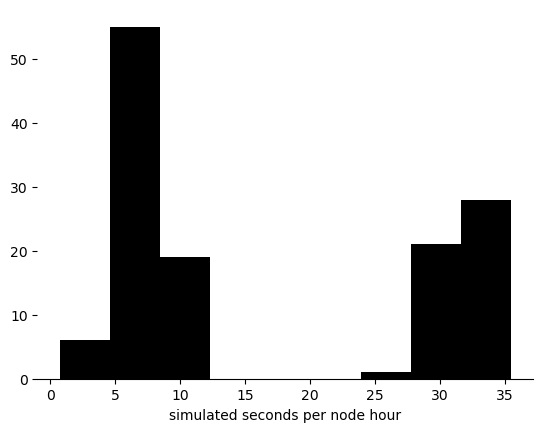

In [11]:
import os
import matplotlib.pyplot as plt

            
def is_smaller_than_limit(path, limit=3e9):
    return os.path.getsize(path) < limit

def is_haukes_log(filename):
    return filename.startswith('LOG.exp.DOM01+DOM02.run.')

def efficiency_estimate_from_logs(log_file_directory='/work/mh0010/m300408/DVC-test/EUREC4A-ICON/EUREC4A/run/logs', identifier=is_haukes_log):
    logs = os.listdir(log_file_directory)
    logs = sorted([f for f in logs if identifier(f)])
    data = list()
    for log in logs:
        full_path = os.path.join(log_file_directory, log)
        if is_smaller_than_limit(full_path): # we exlude log files that are too heavy for our notebook
            try:
                runtime = get_simulated_time(full_path)
                nodes = get_nodes(full_path)
                walltime = get_walltime(full_path)
                nodehours = nodes * walltime
                spn = float(runtime) * 60 * 60 / (nodes * walltime)
                # print(runtime, nodes, walltime, nodehours, spn)
                if 100 > spn > 0 : # we assume that over 100 is too good to be true. near zero walltime can distort this measure.
                    data.append({'nodes':nodes, 'runtime':runtime, 'walltime':walltime, 'spn':spn})
            except: pass
    return data

def fig_efficiency_histogram(log_file_directory='/work/mh0010/m300408/DVC-test/EUREC4A-ICON/EUREC4A/run/logs', identifier=is_haukes_log):
    data = efficiency_estimate_from_logs(log_file_directory=log_file_directory, identifier=identifier)
    print([d['spn'] for d in data])
    fig, ax = plt.subplots()
    ax.hist([d['spn'] for d in data], bins='auto', color='black')
    ax.set_xlabel('simulated seconds per node hour')
    for border in ['top','left','right']: ax.spines[border].set_visible(False)
    return fig, ax
    
fig, ax = fig_efficiency_histogram()
fig.savefig('img/fig_efficiency_histogram_hauke.png')
fig.show()

In [ ]:
print(len(efficiency_estimate_from_logs()), 
      len([f for f in os.listdir('/work/mh0010/m300408/DVC-test/EUREC4A-ICON/EUREC4A/run/logs') if f.startswith('LOG.exp.DOM01+DOM02.run.')]))

Not all available log files are associated with successful runs. Only a few log files (84 out of 382) do deliver the numbers we are looking for in the way we are looking for them. If we look at the distribution we see two separate populations. It seems like the production runs have a efficiency of 30 to 35 simulated seconds per node hour. This would be one simulated day per day while running on 120 nodes.

If we exclude the low efficiency runs, the remaining show a slight linear decrease in efficiency with increasing number of nodes.

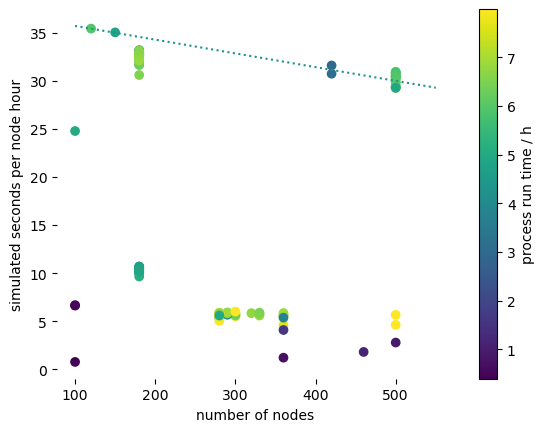

In [12]:
import numpy as np

def fig_efficiency_scatter(log_file_directory='/work/mh0010/m300408/DVC-test/EUREC4A-ICON/EUREC4A/run/logs', identifier=is_haukes_log):
    data = efficiency_estimate_from_logs(log_file_directory=log_file_directory, identifier=identifier)
    nodes = [d['nodes'] for d in data]
    spn = [d['spn'] for d in data]
    walltime = [d['walltime'] for d in data]
    fig, ax = plt.subplots()
    # ax.hist(data, bins='auto', color='black')
    x = np.linspace(100,550,100)
    y = - x/70 + 35 + 15/7
    ax.plot(x,y,color=(32/255,146/255,140/255), ls=':')
    plot = ax.scatter(nodes,spn,c=walltime)
    ax.set_xlabel('number of nodes')
    ax.set_ylabel('simulated seconds per node hour')
    for border in ['top','bottom','left','right']: ax.spines[border].set_visible(False)
    fig.colorbar(plot, label='process run time / h')
    return fig, ax

fig, ax = fig_efficiency_scatter()
fig.savefig('img/fig_efficiency_scatter_hauke.png')
fig.show()

If we look at the runs I performed so far they also show two separate efficiency clusters. One has similar efficiencies between 30 and 35 simulated seconds per node hour. The other cluster seems to be more efficient with around 50 simulated seconds per node hour. Thos might be the runs that only simulated the first few hours. Domain DOM02 with its high computational load starts up after 6 hours.

All my runs use 120 nodes. The shorter runs are the ones with more apparent efficiency, the longer runs are in the same range of efficiency as the original simulations.

/work/mh1126/m300872/eureca_icon/EUREC4A/run/logs/les_4k-adiabat-2851466.log:/work/mh1126/m300872/eureca_icon/EUREC4A/run/logs/les_4k-adiabat-2851562.log:/work/mh1126/m300872/eureca_icon/EUREC4A/run/logs/les_4k-adiabat-2852509.log:/work/mh1126/m300872/eureca_icon/EUREC4A/run/logs/les_4k-adiabat-2852667.log:/work/mh1126/m300872/eureca_icon/EUREC4A/run/logs/les_4k-adiabat-2853187.log:/work/mh1126/m300872/eureca_icon/EUREC4A/run/logs/les_4k-adiabat-2853536.log:/work/mh1126/m300872/eureca_icon/EUREC4A/run/logs/les_4k-adiabat-2854002.log:/work/mh1126/m300872/eureca_icon/EUREC4A/run/logs/les_4k-adiabat-2854424.log:/work/mh1126/m300872/eureca_icon/EUREC4A/run/logs/les_4k-adiabat-2904421.log:/work/mh1126/m300872/eureca_icon/EUREC4A/run/logs/les_4k-adiabat-2904871.log:/work/mh1126/m300872/eureca_icon/EUREC4A/run/logs/les_4k-adiabat-2904984.log:/work/mh1126/m300872/eureca_icon/EUREC4A/run/logs/les_4k-adiabat-2905013.log:/work/mh1126/m300872/eureca_icon/EUREC4A/run/logs/les_4k-adiabat-2905095.log

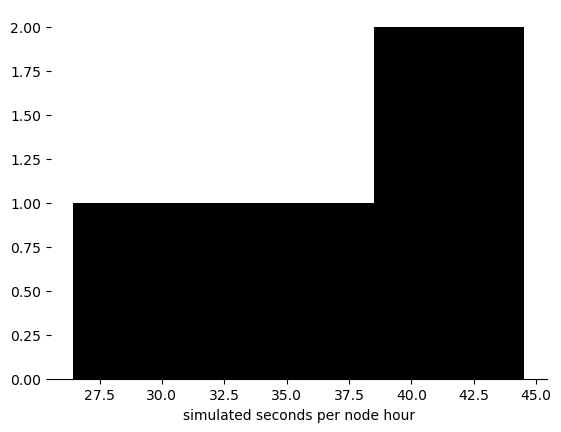

In [28]:
def is_warming_run_log(filename):
    return filename.startswith('les_4k-adiabat')

fig, ax = fig_efficiency_histogram('/work/mh1126/m300872/eureca_icon/EUREC4A/run/logs', identifier=is_warming_run_log)
fig.show()

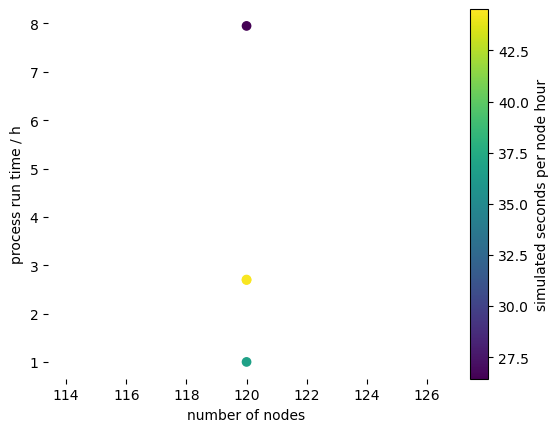

In [14]:
def is_warming_run_log(filename):
    return filename.startswith('les_4k-adiabat')

def fig_efficiency_scatter(log_file_directory='/work/mh0010/m300408/DVC-test/EUREC4A-ICON/EUREC4A/run/logs', identifier=is_haukes_log):
    data = efficiency_estimate_from_logs(log_file_directory=log_file_directory, identifier=identifier)
    nodes = [d['nodes'] for d in data]
    spn = [d['spn'] for d in data]
    walltime = [d['walltime'] for d in data]
    fig, ax = plt.subplots()
    # ax.hist(data, bins='auto', color='black')
    plot = ax.scatter(nodes, walltime, c=spn)
    ax.set_xlabel('number of nodes')
    ax.set_ylabel('process run time / h')
    for border in ['top','bottom','left','right']: ax.spines[border].set_visible(False)
    fig.colorbar(plot, label='simulated seconds per node hour')
    return fig, ax

fig, ax = fig_efficiency_scatter('/work/mh1126/m300872/eureca_icon/EUREC4A/run/logs', identifier=is_warming_run_log)
fig.savefig('img/fig_efficiency_scatter2_hauke.png')
fig.show()

If we want to simulate 40 days (3456000 seconds) and assume the conservative estimate of 30 simulated seconds per node hour, we arrive at an estimate of **115200 node hours needed for a full run**.

In [15]:
# dom01_only_test_log
full_path = '/work/mh1126/m300872/eureca_icon/EUREC4A/run/logs/les_test-7783849.log'
nodes = get_nodes(full_path)
walltime = get_walltime(full_path)
nodehours = nodes * walltime



In [16]:
runtime = get_simulated_time(full_path)
spn = float(runtime) * 60 * 60 / (nodes * walltime)
print(nodes, walltime, nodehours, spn)

120 6.453888888888889 774.4666666666667 32.577257467504516


In [17]:
print(9)

9


*/work/mh1126/m300872/eureca_icon/EUREC4A/run/logs/les_test-7847069.log:*

`FATAL ERROR in mo_input_request_list:InputRequestList_readFile: File is not found: dwdFG_R2B12_DOM01.nc`

In [18]:
# def get_walltime(filename):
#     try:
#         lines = find_matching_lines(filename, 'Elapsed time')
#         lines = lines[0].split(' ')
#         for word in lines:
#             try:
#                 d = pd.Timedelta(word)
#                 if type(d) == type(pd.Timedelta('01h01m01s')): return pd.Timedelta(word).total_seconds() / (60*60)
#             except: pass
#     except: 
#         lines = find_matching_lines(filename, 'total')[-2].split(' ')
#         for word in lines:
#             if word.endswith('m'):
#                 try:
#                     d = pd.Timedelta(word)
#                     if type(d) == type(pd.Timedelta('01h01m01s')): 
#                         return pd.Timedelta(word).total_seconds() / (60*60)
#                 except: pass
    
# dom01_only_test_log
slurm_nr = '7849200'
full_path = f'/work/mh1126/m300872/eureca_icon/EUREC4A/run/logs/les_test-{slurm_nr}.log'
print(full_path)
# nodes = get_nodes(full_path)
walltime = get_walltime(full_path)
print(type(walltime), walltime)
# for v in [nodes, walltime]: print(type(v),v)
# nodehours = nodes * walltime
# runtime = get_simulated_time(full_path)
# spn = float(runtime) * 60 * 60 / (nodes * walltime)
# print(nodes, walltime, nodehours, spn)

/work/mh1126/m300872/eureca_icon/EUREC4A/run/logs/les_test-7849200.log



KeyboardInterrupt



In [ ]:
import os
import xarray as xr

# BASE_DIR = '/work/mh0010/m300408/DVC-test/EUREC4A-ICON/EUREC4A/'
# GRID_DIR = f'{BASE_DIR}/grids'
# grid_path = f'{GRID_DIR}/EUREC4A_PR1250m_DOM01.nc'
# os.path.exists(grid_path)
# xr.open_dataset(grid_path)

date = '20200109'
initdate = '2020010914'
BASE_DIR = f'/work/mh1126/m300872/moist_adiabatic' #changed boundary conditions
INIT_DIR = f'{BASE_DIR}/initc/{date}'
os.listdir(INIT_DIR)
# # add_link_file ${INIT_DIR}/initc_EUREC4A_PR1250m_DOM01_${init_date}.nc dwdFG_R2B12_DOM01.nc
# path = f'{INIT_DIR}/initc_EUREC4A_PR1250m_DOM01_{init_date}.nc'

# print(os.path.exists(path))
# xr.open_dataset(path)

In [2]:
# 2h, 120n = 240nh 
print(2*120, 'node hours')
#2h sim
print(2 * 60 * 60, 'simulated seconds')
print(2 * 60 * 60 / (2*120), 'simulated seconds per node hour')

240 node hours
7200 simulated seconds
30.0 simulated seconds per node hour


In [10]:
import pandas as pd
import os


    
logfile = '/work/mh0010/m300408/DVC-test/EUREC4A-ICON/EUREC4A/run/logs/LOG.exp.DOM01+DOM02.run.562478.o'
log_efficiency_analysis(logfile,1)

walltime:       4.917 
nodes:          500.000 
simulated time: 19.998 

simulated seconds per node hour used: 29.285694915254236


{'walltime': 4.916666666666667,
 'nodes': 500,
 'simulated time': 19.998333333333335,
 'simulated seconds per node hour': 29.285694915254236}

In [6]:
print_log_efficiency_analysis('/work/mh1126/m300872/eureca_icon/EUREC4A/run/logs/DEVtest-7951978.log')

walltime:       0.504 
nodes:          8.000 
simulated time: 0.447 

simulated seconds per node hour used: 399.1174848317705


In [2]:
get_walltime(logfile)

NameError: name 'get_walltime' is not defined